# Test CNN models

Give average accuracies for each task, and generate confusion matrix plots.

In [1]:
import sys
sys.path.append("..")

import os
import json
import numpy as np
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

2024-01-16 04:28:03.109584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 04:28:03.922837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from test_model import plot_cm, model_dir, output_dir
from cnn_data import load_data

Importing lots of stuff...


## Confusion matrix construction

In [3]:
def evaluate_cnn(task_name):
    print(f"Loading data for task {task_name}...")
    X_test, Y_test, _, _ = load_data(task_name)
    print(f"Loading model...")
    cnn = keras.models.load_model(f"{model_dir}/{task_name}_cnn")
    
    Y_pred = np.argmax(cnn.predict(X_test, batch_size=900), axis=1)
    
    cm = confusion_matrix(Y_test, Y_pred).astype(float)
    cm /= np.sum(cm, axis=1, keepdims=True)
    task2label = {
        "scalar1": r"$s\rightarrow\pi^0\pi^0$",
        "axion1": r"$a\rightarrow\gamma\gamma$",
        "axion2": r"$a\rightarrow3\pi^0$"
    }
    labels = [r"$\pi^0$", r"$\gamma$", task2label[task_name]]
    
    os.makedirs(f"{output_dir}/cnn", exist_ok=True)
    plot_cm(
        cm,
        labels=labels,
        save_path=f"{output_dir}/cnn/{task_name}_cm.pdf"
    )
    test_accuracy = np.mean(Y_pred == Y_test)
    print(f"\nMean test accuracy for {task_name}: {test_accuracy:.5f}")
    
    return test_accuracy, cm

Loading data for task scalar1...
load_data from datafile /data/wifeng/photon-jet/data/h5/pi0_40-250GeV_100k.h5
load_data from datafile /data/wifeng/photon-jet/data/h5/gamma_40-250GeV_100k.h5
load_data from datafile /data/wifeng/photon-jet/data/h5/scalar1_40-250GeV_100k.h5
Loading model...


2024-01-16 04:28:12.807090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9804 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5
2024-01-16 04:28:12.808630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9804 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2024-01-16 04:28:12.809966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5
2024-01-16 04:28:14.575755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-01-16 04:28:14.729006: I tensorflow/tsl/platform/default/subprocess.cc:304] Start 

24/24 [==============================] - 1s 10ms/step

Mean test accuracy for scalar1: 0.98862


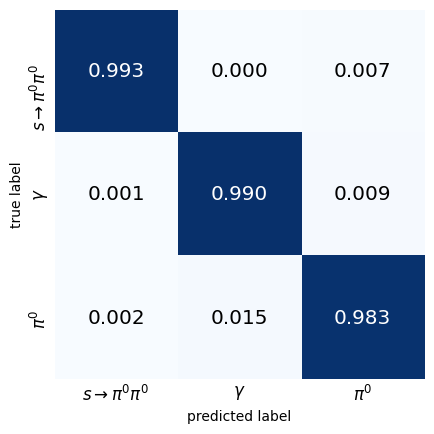

In [4]:
evaluate_cnn("scalar1");